# Production Model GradientBoost Regressor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('fivethirtyeight')

/Users/nelson/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load the Data

Lets load in the pickled GradientBoost object and the train/test data.

In [2]:
gb = pd.read_pickle('../pickles/gbr1539715514.pkl')

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

In [4]:
X_train_sc = pd.read_csv('../data/X_train_sc.csv', header=None)
X_test_sc = pd.read_csv('../data/X_test_sc.csv', header=None)

In [5]:
y_train = pd.read_pickle('../pickles/y_train.pkl')
y_test = pd.read_pickle('../pickles/y_test.pkl')

### Model Plotting Functions

To ensure efficiency in the plotting of both (1) the top related features in the models and (2) line of best fit through predictions I have created two different functions to assist me in that process. 

##### Explanation of Functions

1. **Model Feature Plotting Function:** This function will identify the top 20 highest weighted features that were most influential to the models predictions. It will then be saved with the key of the dictionary from the pipeline (model abbreviation) followed by "feature_importance" in order to uniquely identify which model this plot belongs.
    - The following arguments will be required to run this function:
        1. x: this is the weighted values column from the feature importances data frame created for the model
        2. y: this is the feature importances data frame created for the model (the function will extract the index)
        3. pipe: each of my models will have a pipeline setup prior to use with the model to use
2. **Predictions Plotting Function:** This function will plot model predictions against the actual target values (y_test) and then create the best fit line through the scatter plot starting at point (0,0). It will then be saved with the key of the dictionary from the pipeline (model abbreviation) followed by "model_predictions" in order to uniquely identify which model this plot belongs.
    - The following arguments will be required to run this function:
        1. pipe: each of my models will have a pipeline setup prior to use with the model to use
        2. predictions: the model prediction values (launch speed)
        3. y_test: the actual target variable values (launch speed)

In [6]:
def model_feature_plotting_func(x, y, pipe):
    plt.figure(figsize=(25,12))

    #sns.set(style="white")
    sns.set_context("poster", rc={'patch.linewidth':2})

    plt.title(f'{"_".join(pipe.named_steps.keys()).upper()} Feature Importances (Top 20)', fontsize=35, pad=40)

    a = sns.barplot(x.head(20).values,
                    y.index[0:20].values, 
                    color='#51b73b', 
                    alpha=.5, 
                    edgecolor='k')

    plt.xlabel('Weights', fontsize=30, labelpad=20)

    a.tick_params(labelsize=30,labelcolor="k")
    sns.despine()

    plt.tight_layout();
    plt.savefig(f'../plots/{"_".join(pipe.named_steps.keys())}_feature_importance.png')

In [7]:
def predictions_plotting_func(pipe, predictions, y_test):
    plt.figure(figsize=(28,15))
    plt.title(f'{"_".join(pipe.named_steps.keys()).upper()} Predictions vs Actuals', fontsize=50, pad=40)

    plt.scatter(predictions, y_test, color='#069af3', s=500, edgecolors='k', alpha=.4, lw=2)
    plt.plot([0, 122], [0, 122], color='#fd3c06', lw=7, alpha=.8)

    plt.xlim([70, 120])
    plt.ylim([70, 120])

    plt.xlabel('Predictions', fontsize=40, labelpad=20)
    plt.ylabel('Actuals', fontsize=40, labelpad=20)

    plt.tick_params(labelsize=40,labelcolor="k")

    sns.despine()

    plt.legend(['Line of Best Fit'], fontsize=30)
    plt.tight_layout()
    
    plt.savefig(f'../plots/{"_".join(pipe.named_steps.keys())}_model_predictions.png')

### GradientBoost Model 

Lets remind ourselves of the train and test scores from the GradientBoost model. 

|Train Score |Test Score |
|------------|-----------|
|   0.68038  |  0.61657  |


##### Interpretations

1. The train data explained variance (R2) means, 68% of the variations in the predicted launch speeds can be explained by the feature variables within the model.

2. The test data explained variance (R2) means, 61% of the variations in the predicted launch speeds can be explained by the feature variables within the model.

3. Overall, this model is still over fit but the percentage of explained variance is the best I've seen amongst all models.

In [8]:
test = gb.score(X_test_sc, y_test)
train = gb.score(X_train_sc, y_train)
print(f'Model Train {train}')
print(f'Model Test {test}')

Model Train 0.680384206966165
Model Test 0.6165711841636452


#### Pipeline and Parameters

Pipelines are the sklearn method that take in a sequential list of steps that end with the appropriate estimator or model that you are planning to run.

Parameters should be a dictionary with the keys referencing the different steps and parameters you are looking to tune followed by the values for that parameter that you are looking to tune through the search.

In [9]:
pipe_gb = Pipeline([
    ('gbr', GradientBoostingRegressor())
])

In [10]:
params_gb = {
    'gbr__n_estimators':[200, 210, 220],
    'gbr__max_depth':[3, 5, 7]
}

In [11]:
gb.best_params_

{'gbr__max_depth': 3, 'gbr__n_estimators': 210}

In [12]:
gb.best_estimator_

Pipeline(memory=None,
     steps=[('gbr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=210, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

#### GradientBoost Feature Importance

So, what is influencing home run exit velocities?

Using, the feature importances method I can obtain which features supplied the most influence in predicting a batters home run. I will focus on the top 20 features.

**Top 20 Features:**
- `launch_angle`: how high, in degrees, a ball was hit by a batter.
- `hit_distance_sc`: the distance the ball traveled from home plate
- `ay`: the acceleration of the pitch, in feet per second per second, in three dimensions, measured at the initial point.
- `plate_x`: strike zone coordinate x
- `weight`: the weight in lbs of the player that hit the home run
- `plate_z`: strike zone coordinate z
- `effective_speed`: the (actual) speed of the pitch upon the ball crossing home plate
- `sz_bottom`: the distance in feet from the ground to the bottom of the current batter’s rulebook strike zone. The PITCHf/x operator sets a line at the hollow of the knee for the bottom of the zone.
- `release_spin_rate`: how much spin, in revolutions per minute, a pitch was thrown with upon release.
- `release_pos_z`: the release coordinates in three dimensions, measure at the initial release point.
- `sz_top`: the distance in feet from the ground to the top of the current batter’s rulebook strike zone as measured from the video by the PITCHf/x operator. The operator sets a line at the batter’s belt as he settles into the hitting position, and the PITCHf/x software adds four inches up for the top of the zone
- `vx0`: the velocity of the pitch, in feet per second, in three dimensions, measured at the initial point.
- `height`: the height in inches of the player that hit the home run
- `pfx_x`: the horizontal movement, in inches, of the pitch between the release point and home plate, as compared to a theoretical pitch thrown at the same speed with no spin-induced movement. This parameter is measured at y=40 feet regardless of the y0 value.
- `pfx_z`: the vertical movement, in inches, of the pitch between the release point and home plate, as compared to a theoretical pitch thrown at the same speed with no spin-induced movement. This parameter is measured at y=40 feet regardless of the y0 value.
- `vz0`: the velocity of the pitch, in feet per second, in three dimensions, measured at the initial point.
- `release_pos_x`: the release coordinates in three dimensions, measure at the initial release point.
- `az`: the acceleration of the pitch, in feet per second per second, in three dimensions, measured at the initial point.
- `release_pos_y`: the release coordinates in three dimensions, measure at the initial release point.
- `ax`: the acceleration of the pitch, in feet per second per second, in three dimensions, measured at the initial point.

In [13]:
columns = X_train.columns
coef_weights = pd.DataFrame(gb.best_estimator_.named_steps['gbr'].feature_importances_.ravel(),
                            index=X_train.columns, columns=['coef_weights'])
coef_weights.sort_values('coef_weights', ascending=False, inplace=True)
coef_weights.head()

,coef_weights
launch_angle,0.165535
hit_distance_sc,0.164041
ay,0.067055
plate_x,0.062734
weight,0.057066


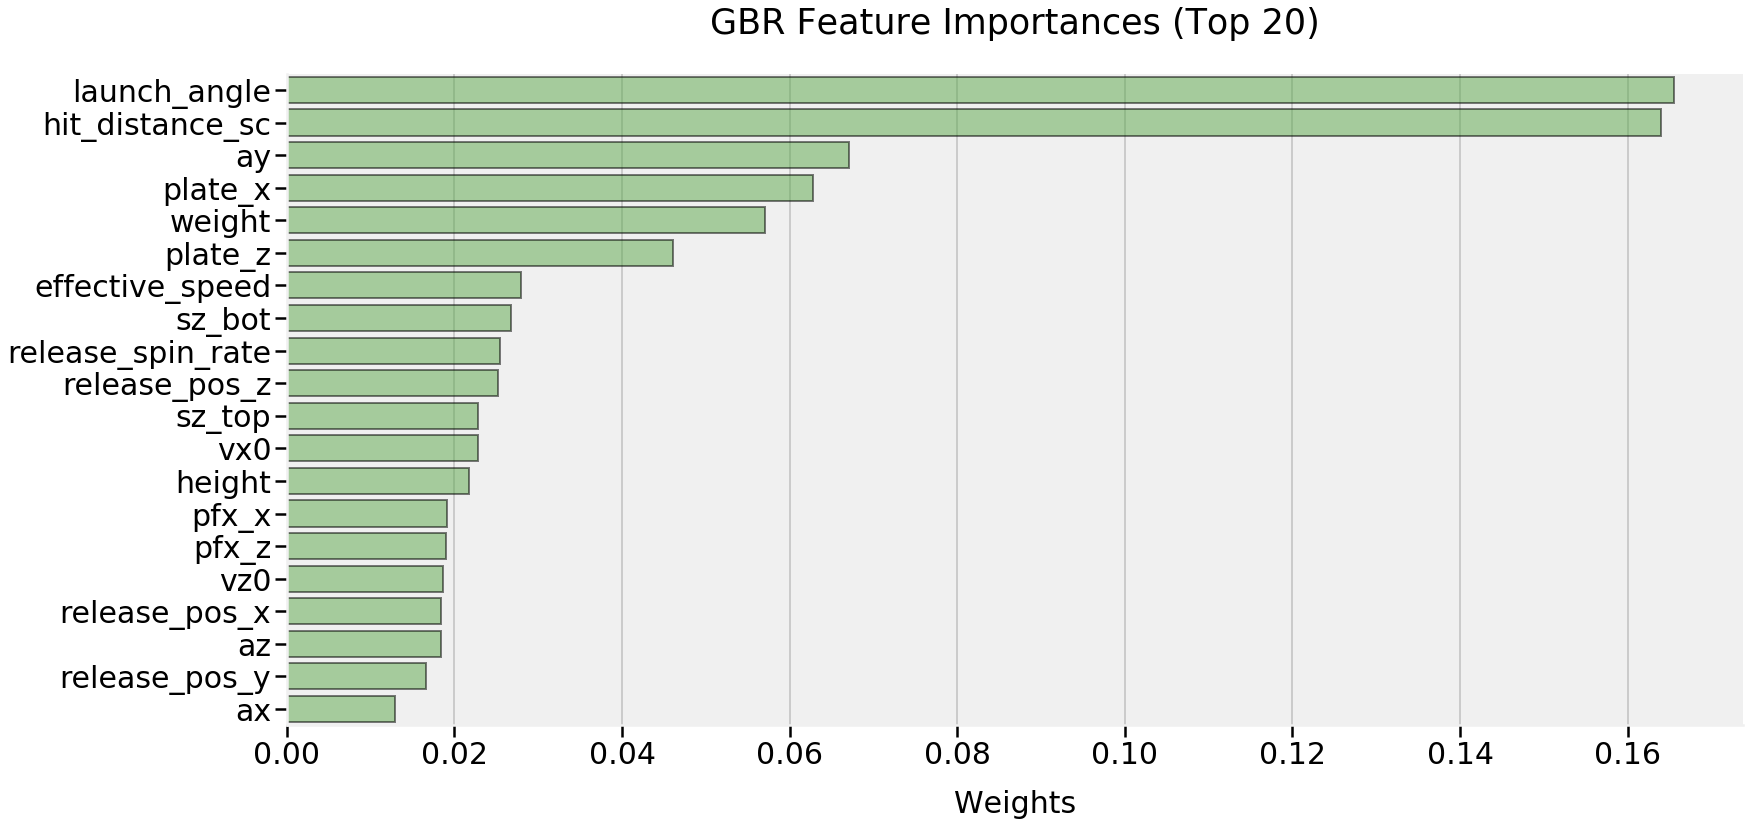

In [14]:
model_feature_plotting_func(coef_weights['coef_weights'], coef_weights, pipe_gb)

#### GradientBoost Predictions

Lets take a look at the GradientBoost Launch Speed Predictions plotted against the Launch Speed Actuals.

##### Interpretation

The below scatter plot is zoomed into the data in order to get a better idea about how the predictions are plotting against the actuals. The closer the scatter observations are to the line of best fit means we are able to explain more variance and have less error (or risiduals) in the predictions.

The GradientBoost Predictions vs Actuals plot below shows small signs of over fitting but looks to be in good shape with one outlier.

In [15]:
predictions_gb = gb.predict(X_test_sc)
predictions_gb

array([105.41697644, 100.43190058, 107.48483652, ..., 102.99259682,
       106.73297381, 103.72525058])

In [16]:
predictions_gb.max(), y_test.max()

(115.82707069878175, 121.1)

In [17]:
predictions_gb.min(), y_test.min()

(90.54621308019175, 76.6)

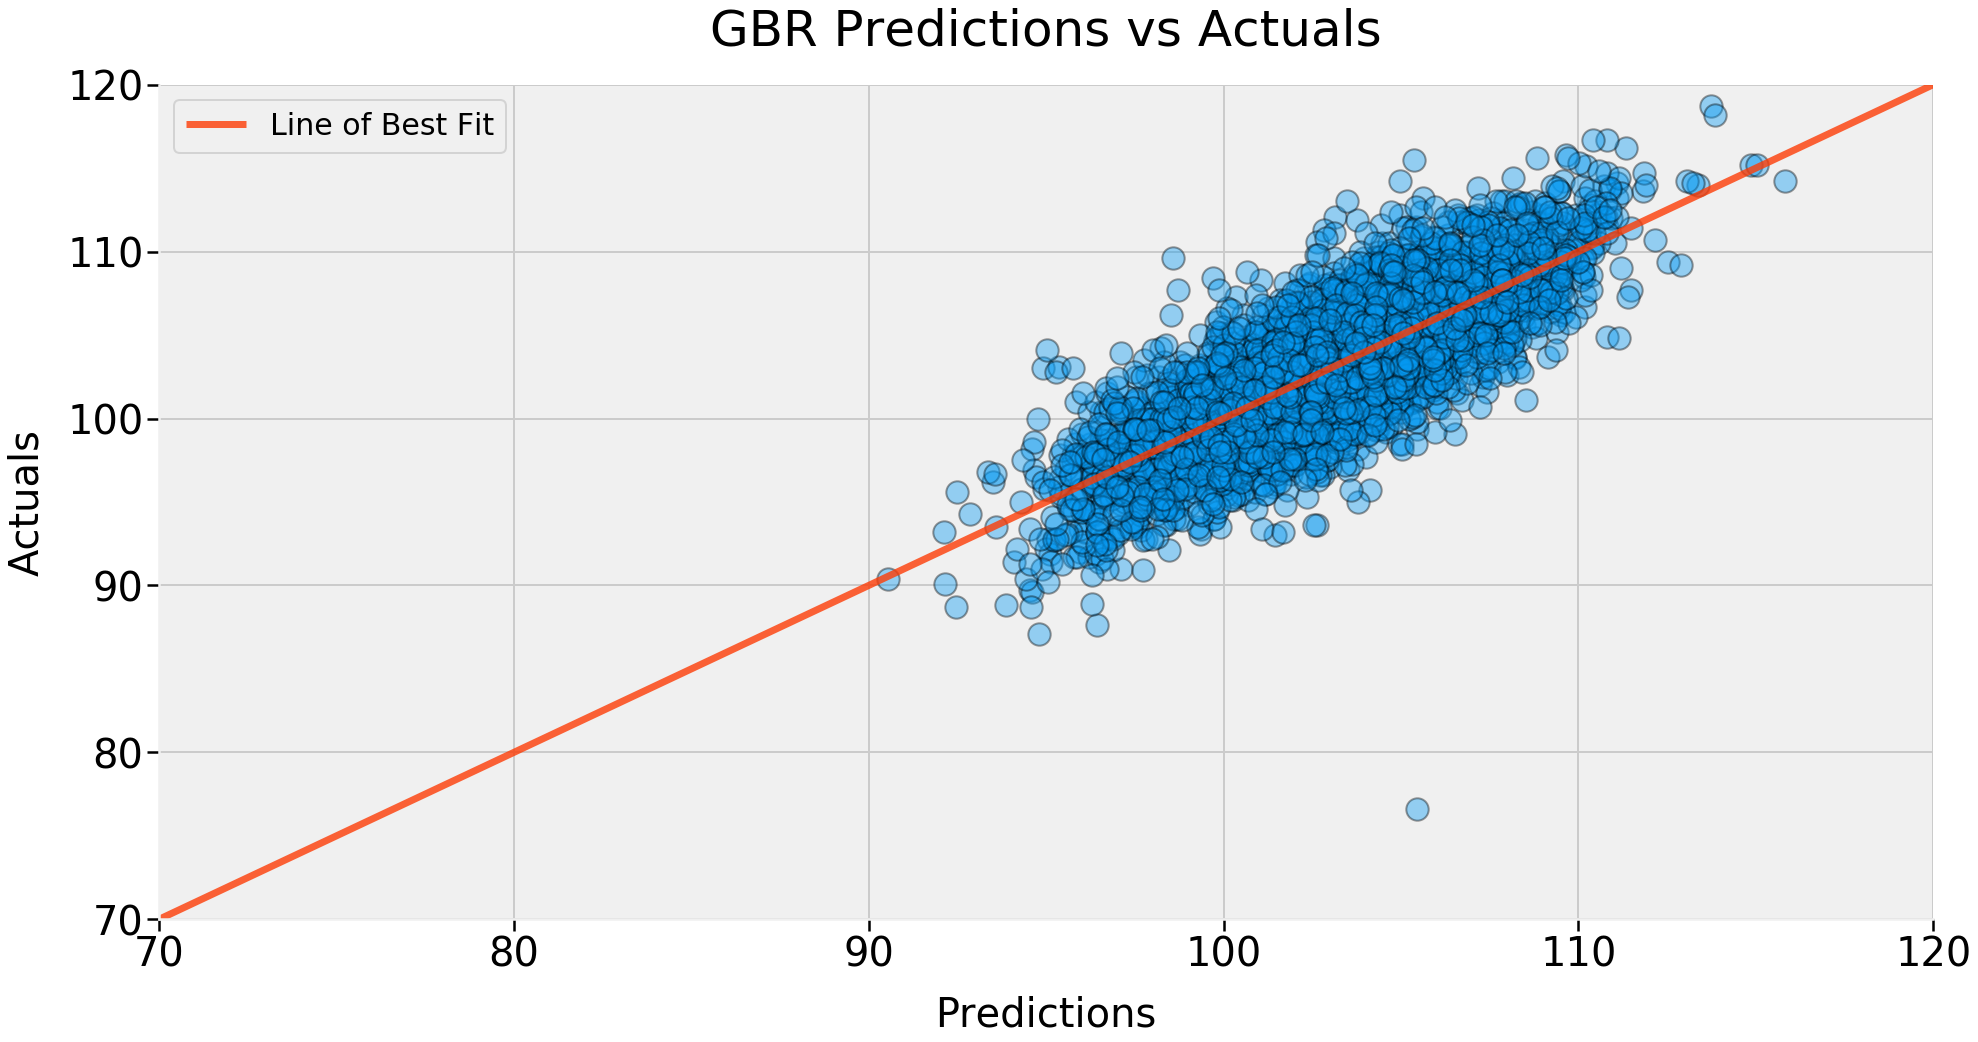

In [18]:
predictions_plotting_func(pipe_gb, predictions_gb, y_test)

#### GradientBoost Metrics

Now that we've gotten predictions from our model lets review the metrics for the predictions against the actuals and compare them back to the baseline scores to see how the model performed.

**Baseline Scores:**

|    R2    |   RMSE   | Launch Speed Mean |
|----------|----------|-------------------|
|    0     |    4.36  |       103.29      |

**GradientBoost Scores:**

|    R2    |   RMSE   | Launch Speed Mean |
|----------|----------|-------------------|
|   0.616  |   2.70   |      103.22       |


##### Interpretation

1. **R2:** Definitely an improvement. The baseline R2 predicted was 0 and we could only get better from there.
2. **RMSE:** Another improvement. The GBR RMSE is less than the Baseline RMSE meaning that on average the predictions on launch speed with GBR are only off by around 2.70 mph.
3. **Launch Speed:** Almost equal. The GBR Launch Speed predictions had an average of 103.22 and we were aiming to be around the Baseline Launch Speed of 103.29 so only off by about .07.

In [19]:
f'GBR R2: {r2_score(y_test, predictions_gb)}'

'GBR R2: 0.6165711841636452'

In [20]:
f'GBR RMSE: {np.sqrt(mean_squared_error(y_test, predictions_gb))}'

'GBR RMSE: 2.7034865764784137'

In [21]:
f'GBR Average Launch Speed: {predictions_gb.mean()}'

'GBR Average Launch Speed: 103.22556160662106'

### Save Predictions

In [22]:
with open('../pickles/gb_predictions.pkl', 'wb+') as f:
    pickle.dump(predictions_gb, f)

## Home Run Exit Velocities Conclusions and Next Steps

### Model

From the data I collected from Baseball Savant on pitch information, the data from the sample of baseballs used in the 2015, 2016 and 2017 seasons and the web scrape data of each batters age, height and weight the features I saw that most influenced a batters home run exit velocity relates to the pitch stats, as well as the height and the weight of the player. These two groups made up all of the top 20 most influential features to the Gradient Boost model and provided the model the necessary information it needed to be as accurate as it was in predicting. 

As far as the baseballs, I don't see any significant evidence that the ball has any affect on a batters launch speed. The most important baseball features carried the following weights in the model:
- Avg CCOR: 0.001344
- Avg DS: 0.003617
- Weight: 0.0

### Next Steps

During EDA I found that there were more Fly Ball home runs were hit in the 2017 season than in the 2015 and 2016 seasons and it was actually significally more Fly Ball home runs than either of the previous two seasons. I would like to review what has triggered batters to adjust to hitting more Fly Ball home runs along with reviewing some research that reviews the drag coefficient of the baseball to determine if the ball is having any affect on the flight after being hit and ultimately leaving the ball park for a home run.
- https://fivethirtyeight.com/features/in-mlbs-new-home-run-era-its-the-baseballs-that-are-juicing/

Another area I would like to build on is adding more pitch observations to my data in order to analyze pitches that are not hit for home runs. I think that this would provide additional insights into the types of pitches that batters are able to hit out of the park on a regular basis. This would also provide additional examples to be examined related to batted ball types (Fly Balls or Line Drives) to continue to build on the idea that batters are adjusting their swings in order to hit more Fly Balls.